In [62]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time
from acquire import player_season_3pa
import explore

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
#calling in the data:
from acquire import tome_prep
df = tome_prep()

In [3]:
#looking at data size and info:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84164 entries, 0 to 94709
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        84164 non-null  object 
 1   player_id     84164 non-null  int64  
 2   team          84164 non-null  object 
 3   team_id       84164 non-null  int64  
 4   game_id       84164 non-null  int64  
 5   home          84164 non-null  bool   
 6   period        84164 non-null  int64  
 7   abs_time      84164 non-null  int64  
 8   play_time     84164 non-null  float64
 9   since_rest    84164 non-null  float64
 10  loc_x         84164 non-null  int64  
 11  loc_y         84164 non-null  int64  
 12  zone          84164 non-null  object 
 13  shot_type     84164 non-null  object 
 14  score_margin  84164 non-null  int64  
 15  points        84164 non-null  int64  
 16  fg_pct        84164 non-null  float64
 17  shot_result   84164 non-null  object 
dtypes: bool(1), float64(3), in

In [5]:
#stats on numeric variables:
df.describe()

,player_id,team_id,game_id,period,abs_time,play_time,since_rest,loc_x,loc_y,score_margin,points,fg_pct
count,8.416400e+04,8.416400e+04,8.416400e+04,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000
mean,1.149216e+06,1.610613e+09,2.210061e+07,2.498123,1446.721104,1063.294047,328.168348,-7.751414,165.757533,0.516183,8.562164,0.530262
std,6.770433e+05,8.585147e+00,3.562261e+02,1.134161,839.909211,593.762525,248.000846,168.748218,93.284885,11.974491,8.140890,0.320773
min,2.544000e+03,1.610613e+09,2.210000e+07,1.000000,6.000000,6.000000,0.300000,-250.000000,-48.000000,-75.000000,0.000000,0.000000
25%,2.034960e+05,1.610613e+09,2.210030e+07,1.000000,716.750000,612.000000,138.000000,-172.000000,79.000000,-6.000000,3.000000,0.320000
50%,1.628370e+06,1.610613e+09,2.210061e+07,2.000000,1440.000000,1025.000000,275.000000,-12.000000,203.000000,0.000000,6.000000,0.500000
75%,1.629643e+06,1.610613e+09,2.210092e+07,3.000000,2160.000000,1466.000000,456.000000,156.000000,241.000000,7.000000,12.000000,0.750000
max,1.630994e+06,1.610613e+09,2.210123e+07,7.000000,3771.000000,3247.000000,2742.000000,250.000000,299.000000,78.000000,79.000000,1.000000


### Univariates:

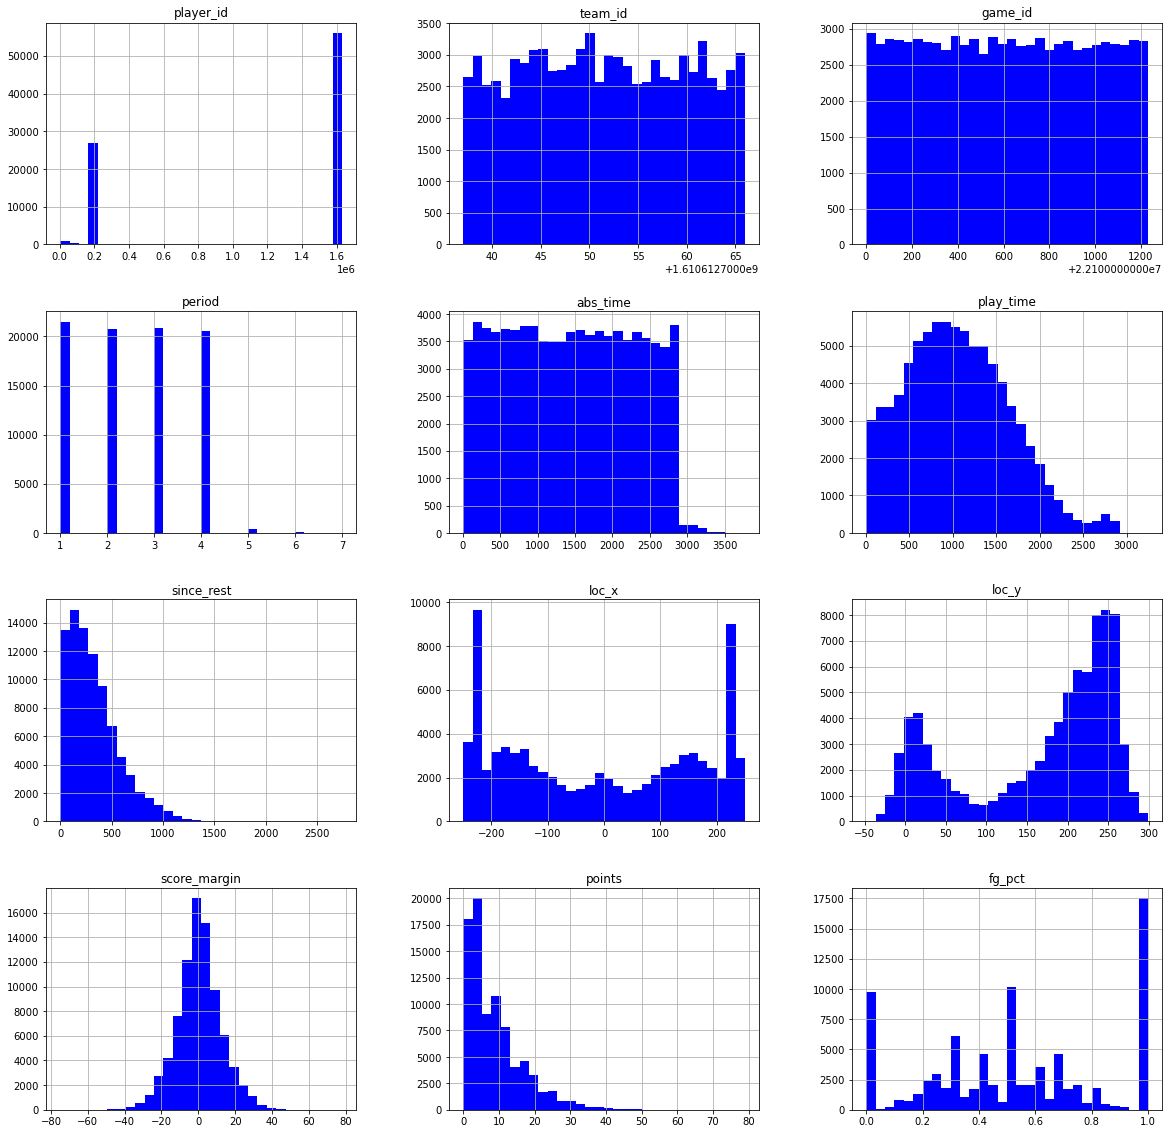

In [64]:
#what is the shape of the numeric data? 
explore.univariate(df)

### Takeaways:
- Play and rest times have clear right-skewed data.
- it is interesting to see that 3pt shots are happening more often in certain locations on the court. (see loc_x)
- score margin seems to be normally distributed
- points made by player are right skewed

### Splitting data on train, validate, test to keep integrity of data and only predict on a portion of the data.

In [10]:
#importing splitter function from splitter.py
from splitter import splitter
train, validate, test=splitter(df, target = 'shot_result', train_split_1 = .8, train_split_2 = .7, random_state = 123)

Train = 47131 rows (56.0%) | Validate = 20200 rows (24.0%) | Test = 16833 rows (20.0%)


In [12]:
#checking out what train looks like:
train.head()

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result
22101,Jeff Green,201145,Denver Nuggets,1610612743,22100794,True,1,166,166.0,166.0,-230,-6,R Center,Jump Shot,2,0,0.00,Missed Shot
54605,RJ Barrett,1629628,New York Knicks,1610612752,22101140,True,2,1077,742.0,22.0,200,138,L Below Break/Corner,Jump Shot,0,10,0.83,Missed Shot
12186,Jonas Valanciunas,202685,New Orleans Pelicans,1610612740,22100179,True,1,74,74.0,74.0,-83,257,Center,Jump Shot,-3,0,0.00,Missed Shot
19168,Reggie Bullock,203493,Dallas Mavericks,1610612742,22100954,True,1,369,369.0,369.0,11,267,L Center,Pullup Jump shot,-6,0,0.00,Missed Shot
80553,Bojan Bogdanovic,202711,Utah Jazz,1610612762,22101150,True,3,1697,818.0,257.0,-223,5,R Center,Jump Shot,6,6,0.27,Missed Shot


### Exploring Target Variable: shot result

In [13]:
#looking at values:
train.shot_result.value_counts()

Missed Shot    30295
Made Shot      16836
Name: shot_result, dtype: int64

In [15]:
#putting into percentages:
train.shot_result.value_counts(normalize=True)

Missed Shot    0.642783
Made Shot      0.357217
Name: shot_result, dtype: float64

In [14]:
#looking at overall Made shot rate:
made_shot_rate=train.shot_result.value_counts(normalize=True)[1]

### Overall Made shot rate is 36%

I want to see the rates based on:
- Player(missed/made)
- Team
- Game
- Shot type
- Period

In [26]:
#using a function by Stephen FitzSimon that takes in a predicted outcome
#and returns the rate based on the feature against target variable:

def get_pct_outcome(df, shot_cols = ['player']):
    outputs = []
    for cat in shot_cols:
        for subcat in list(df[cat].unique()):
            for outcome in list(df['shot_result'].unique()):
                output = {
                    'player_name': cat,
                    'sub_col': subcat,
                    'outcome': outcome,
                    'total_shots_made':(df[df[cat]==subcat].shot_result == outcome).sum(),
                    'proportion': (df[df[cat]==subcat].shot_result == outcome).mean()
                }
                outputs.append(output)
    return pd.DataFrame(outputs)

get_pct_outcome(train)

,player_name,sub_col,outcome,total_shots_made,proportion
0,player,Jeff Green,Missed Shot,59,0.702381
1,player,Jeff Green,Made Shot,25,0.297619
2,player,RJ Barrett,Missed Shot,127,0.641414
3,player,RJ Barrett,Made Shot,71,0.358586
4,player,Jonas Valanciunas,Missed Shot,59,0.641304
...,...,...,...,...,...
1071,player,Cameron Oliver,Made Shot,1,1.000000
1072,player,Wayne Selden,Missed Shot,1,1.000000
1073,player,Wayne Selden,Made Shot,0,0.000000
1074,player,David Johnson,Missed Shot,1,1.000000


In [27]:
#creating an object to ask questions on:
proportion_df = get_pct_outcome(train)

### Which players have the higher made rates?

In [73]:
top_3pt_shooters = proportion_df[(proportion_df.proportion > made_shot_rate) & (proportion_df.outcome == 'Made Shot')]
top_3pt_shooters.sort_values(by='proportion', ascending=True)

,player_name,sub_col,outcome,total_shots_made,proportion
363,player,Trey Murphy III,Made Shot,39,0.357798
397,player,Tre Mann,Made Shot,53,0.358108
7,player,Reggie Bullock,Made Shot,77,0.358140
3,player,RJ Barrett,Made Shot,71,0.358586
5,player,Jonas Valanciunas,Made Shot,33,0.358696
...,...,...,...,...,...
1037,player,Bruno Fernando,Made Shot,1,1.000000
1041,player,Kai Jones,Made Shot,1,1.000000
1047,player,Xavier Sneed,Made Shot,1,1.000000
975,player,Gabriel Deck,Made Shot,2,1.000000


### Takeaways:
This gives us a good list of players that are shooting higher than the 35.7% made-shot rate of the NBA overall.

I'll take out the the 1 shot-wonders however, so as not to skew the data.

In [32]:
#looking at value_counts()
top_3pt_shooters.total_shots_made.value_counts()

1      12
2       9
4       8
3       7
12      6
       ..
129     1
103     1
102     1
98      1
48      1
Name: total_shots_made, Length: 100, dtype: int64

### What is the average of 3pt shots made per season?

In [36]:
#determining average of 3pt shots made per season:
top_3pt_shooters.total_shots_made.mean()

46.02272727272727

_____________________________________________

### Which teams have the highest rate of making 3pt shots?

In [50]:
### Looking a proportions of 3pt shots based on teams:
def get_pct_outcome(df, shot_cols = ['col']):
    outputs = []
    for cat in shot_cols:
        for subcat in list(df[cat].unique()):
            for outcome in list(df['shot_result'].unique()):
                output = {
                    'main_category': cat,
                    'sub_category': subcat,
                    'outcome': outcome,
                    'total_shots_made':(df[df[cat]==subcat].shot_result == outcome).sum(),
                    'proportion': (df[df[cat]==subcat].shot_result == outcome).mean()
                }
                outputs.append(output)
    return pd.DataFrame(outputs)

get_pct_outcome(train, shot_cols= ['team'])

,main_category,sub_category,outcome,total_shots_made,proportion
0,team,Denver Nuggets,Missed Shot,1055,0.641727
1,team,Denver Nuggets,Made Shot,589,0.358273
2,team,New York Knicks,Missed Shot,1042,0.644802
3,team,New York Knicks,Made Shot,574,0.355198
4,team,New Orleans Pelicans,Missed Shot,969,0.665522
5,team,New Orleans Pelicans,Made Shot,487,0.334478
6,team,Dallas Mavericks,Missed Shot,1098,0.652019
7,team,Dallas Mavericks,Made Shot,586,0.347981
8,team,Utah Jazz,Missed Shot,1133,0.631902
9,team,Utah Jazz,Made Shot,660,0.368098


In [51]:
#creating an object to apply to teams:
team_prop_df = get_pct_outcome(train, shot_cols= ['team'])

In [75]:
# result of top teams that make 3pt shots:
top_3pt_teams = team_prop_df[(team_prop_df.proportion > made_shot_rate) & (team_prop_df.outcome == 'Made Shot')]
top_3pt_teams

,main_category,sub_category,outcome,total_shots_made,proportion
1,team,Denver Nuggets,Made Shot,589,0.358273
9,team,Utah Jazz,Made Shot,660,0.368098
15,team,Milwaukee Bucks,Made Shot,625,0.362950
21,team,Chicago Bulls,Made Shot,532,0.388605
23,team,Minnesota Timberwolves,Made Shot,665,0.363786
27,team,Miami Heat,Made Shot,629,0.388992
31,team,Boston Celtics,Made Shot,591,0.359927
33,team,Charlotte Hornets,Made Shot,629,0.370218
37,team,Los Angeles Clippers,Made Shot,582,0.380641
39,team,Golden State Warriors,Made Shot,626,0.365868


______________________

### Which Shot types have higher 3pt shot rates?

In [55]:
shot_type_prop = get_pct_outcome(train, shot_cols= ['shot_type'])
best_shot_types = shot_type_prop[(shot_type_prop.proportion > made_shot_rate) & (shot_type_prop.outcome == 'Made Shot')]
best_shot_types

,main_category,sub_category,outcome,total_shots_made,proportion
3,shot_type,Pullup Jump shot,Made Shot,2081,0.359103
7,shot_type,Running Jump Shot,Made Shot,632,0.430225
9,shot_type,Running Pull-Up Jump Shot,Made Shot,309,0.406579
13,shot_type,Jump Bank Shot,Made Shot,50,0.581395
19,shot_type,Step Back Bank Jump Shot,Made Shot,6,0.461538
25,shot_type,Driving Floating Bank Jump Shot,Made Shot,2,0.666667


________________

### Which zones have higher rates of shots made?

In [65]:
zone_prop = get_pct_outcome(train, shot_cols= ['zone'])
best_zones = zone_prop[(zone_prop.proportion > made_shot_rate) & (zone_prop.outcome == 'Made Shot')]
best_zones

,main_category,sub_category,outcome,total_shots_made,proportion
1,zone,R Center,Made Shot,2562,0.384742
3,zone,L Below Break/Corner,Made Shot,2146,0.361950
11,zone,R Below Break/Corner,Made Shot,2314,0.378228


________________________________

### Hypothesis Tests: 

#### Hypothesis 1): 3pt shots made have a relationship with the type of shot taken.

In [69]:
alpha = 0.05
null_hypothesis = "3pt shot result and shot type are independent"
alternative_hypothesis = "there is a relationship between 3pt shot results and shot type"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(df.shot_result, df.shot_type)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p



Reject the null hypothesis that 3pt shot result and shot type are independent
Sufficient evidence to move forward understanding that there is a relationship between 3pt shot results and shot type


7.43896465212482e-16

#### Hypothesis 2): 3pt shots made have a relationship with where the shot was taken.

In [70]:
alpha = 0.05
null_hypothesis = "3pt shot result and zone shot from are independent"
alternative_hypothesis = "there is a relationship between 3pt shot results and zone shot from"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(df.shot_result, df.zone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p



Reject the null hypothesis that 3pt shot result and zone shot from are independent
Sufficient evidence to move forward understanding that there is a relationship between 3pt shot results and zone shot from


9.291986524141443e-18

#### Hypothesis 3): 3pt shots made have a relationship with where the shot was taken.